# Import des librairies + paramètres

In [1]:
import warnings; warnings.simplefilter('ignore')
from P7_toolbox import *

import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
import scipy             as sp
import quantecon         as qe
import time

# pandas settings
pd.set_option('display.max_row', 110)
pd.set_option('display.max_column', 110)

# matplotlib settings
%matplotlib inline
plt.style.use('default')
plt.rcParams.update({'font.size': 20})

# Cahier des charges du Projet 7

## Mission : Effectuer une prédiction de revenus
## Objectifs : 
### Construire + Interpréter régression linéaire multiple
### Maîtriser les bases des probabilités
### Utiliser une ANOVA
### les 3 caractéristiques de la régression linéaire multiple
- le revenu des parents. 
- le revenu moyen du pays dans lequel habite le prospect (l'enfant des parents clients) #probabilités
- l'indice de Gini calculé sur les revenus des habitants du pays en question. 

## Condition :
- utiliser le **Purchasing Power Parity** : parité du pouvoir d'achat de la colonne income.
- Quoi : revenus avec une unité commune, moyenne géométrique des taux de change des biens de consommation.
- Pourquoi : rend la comparaison des pays pour les revenus possible.

## Sources :
- World Income Distribution : pour les quantiles de revenus (exprimés en PPP)
- Banque mondiale : indice de Gini + population totale (2001 - 2020)

### MISSION 1 : statistique descriptive 
    1. année(s) des données utilisées    
    2. nombre de pays présents. "ce modèle doit être valable pour la plupart des pays du monde".
    3. pourcentage de population mondiale couverte par l'analyse.

#### World Income Distribution
- Type de quantile : centile
- intérêt d'utilisation des quantiles : 
    1. répartir uniformément une population en parts égales
    2. rend la comparaison entre pays possible

#### Explications **Purchasing Power Parity** : parité du pouvoir d'achat de la colonne income.
- Quoi : revenus avec une unité commune, moyenne géométrique des taux de change des biens de consommation.
- Pourquoi : rend la comparaison des pays pour les revenus possible.
- Problématique : besoin de transformer la moyenne géométrique en arithmétique pour la normalité.

### Création de l'indice de Gini par pays avec la source worldbank
Méthodologie : 
- chercher l'année la plus renseignée
- remplir les vides de cette année par la moyenne du gini de la décennie des pays

Explication :
- La variation du gini par pays de la décennie écoulée est moins impactante que sa valeur centrale

In [2]:
# data preparation : gini
gini = pd.read_csv('./dataset/worldbank_gini_population.csv')
gini = gini[gini['Series Name']=='Gini index (World Bank estimate)']
gini = gini.replace('..', np.nan)
gini = gini.iloc[:, 2:]
gini.iloc[:, 2:] = gini.iloc[:, 2:].astype(float)

# best filled with gini column
column_number = gini.iloc[:, 2:].isna().sum().argmin()
column_name = gini.iloc[:,(2 + column_number)].name

# find 2010 empty lines
empty_lines_2010 = gini.loc[:, column_name].isna().index

# country's means in 2010 empty lines
gini.loc[empty_lines_2010, column_name] = np.nanmean(gini.iloc[empty_lines_2010, 2:], axis=1)

# keeping 2010 only
gini = gini.iloc[:, [0, 1, column_number + 2]]
gini = gini.dropna()
gini.columns = ['country_name', 'country_code', 'gini_index']
gini = gini.set_index('country_code')

# round by 2 decimals
gini['gini_index'] = gini['gini_index'].round(2)

# 193 : 2010 google's number of countries 
print('ratio pays représentés', gini.shape[0]/193)
print('année retenue : 2010')
gini

ratio pays représentés 0.8290155440414507
année retenue : 2010


,country_name,gini_index
country_code,,
ALB,Albania,31.96
DZA,Algeria,27.60
AGO,Angola,47.00
ARG,Argentina,45.50
ARM,Armenia,32.16
...,...,...
VNM,Vietnam,36.21
PSE,West Bank and Gaza,34.53
YEM,"Yemen, Rep.",35.70


In [3]:
population_ratio(gini.index)

data population / total population  0.9751194986956522


### MISSION 2

- Classement par indice de Gini : TOP 5 asc + desc + moyenne + Place de la France

In [4]:
gini = gini.sort_values(by='gini_index', ascending=False)
gini = gini.reset_index()
print(gini.head(5))
print(gini.tail(5))
print(gini[gini['country_name']=='France'])
gini['gini_index'].describe()

  country_code  country_name  gini_index
0          ZAF  South Africa       63.55
1          NAM       Namibia       61.13
2          BWA      Botswana       59.50
3          BRA        Brazil       54.64
4          HND      Honduras       54.38
    country_code     country_name  gini_index
155          DNK          Denmark       26.93
156          SVK  Slovak Republic       26.61
157          UKR          Ukraine       26.45
158          CZE   Czech Republic       26.26
159          SVN         Slovenia       24.89
    country_code country_name  gini_index
128          FRA       France       32.05


count    160.000000
mean      38.885000
std        7.728228
min       24.890000
25%       32.715000
50%       37.705000
75%       43.575000
max       63.550000
Name: gini_index, dtype: float64

- graphique distribution de revenus : montrer la diversité des cas ( 5-10 pays )

In [5]:
# income distribution graph
incomes = pd.read_csv('./dataset/world_income_distribution.csv', 
                      usecols=['country', 'quantile', 'income'], decimal=',')

incomes['income_log'] = np.log(incomes['income'])

countries = pd.pivot_table(incomes, index='country', columns='quantile', values='income_log',fill_value=0)

from scipy.cluster.hierarchy import linkage
linkage_matrix = linkage(countries, method='median', metric='euclidean', optimal_ordering=True)

from scipy.cluster.hierarchy import fcluster
groups = fcluster(linkage_matrix, criterion='maxclust', t=5, depth=3)

countries['group'] = groups.reshape(-1,1)

for group_number in countries['group'].unique():
    index = countries[countries['group']==group_number].index
    print(gini[gini['country_code'].isin(index)])
    print(gini[gini['country_code'].isin(index)].mean())
    
selected_countries = ['UKR', 'IND', 'FRA', 'CIV', 'LTU']

    country_code            country_name  gini_index
0            ZAF            South Africa       63.55
3            BRA                  Brazil       54.64
4            HND                Honduras       54.38
5            COL                Colombia       53.32
8            PAN                  Panama       52.57
11           PRY                Paraguay       50.91
13           BOL                 Bolivia       50.44
15           VEN           Venezuela, RB       49.72
16           CRI              Costa Rica       49.08
18           ECU                 Ecuador       48.61
19           MEX                  Mexico       48.53
22           NIC               Nicaragua       47.95
23           DOM      Dominican Republic       47.87
25           PER                    Peru       47.11
30           CHL                   Chile       46.63
33           ARG               Argentina       45.50
34           SLV             El Salvador       44.63
35           MYS                Malaysia      

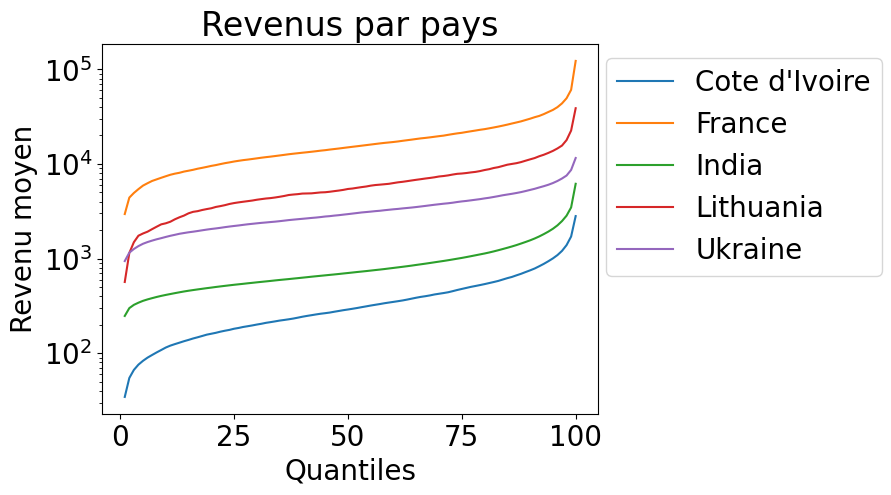

In [6]:
incomes_filter = incomes[incomes['country'].isin(selected_countries)]

# including large names
incomes_filter = incomes_filter.merge(gini[['country_code', 'country_name']], 
                                      left_on='country', right_on='country_code')

incomes_filter = incomes_filter.iloc[:, 1:]

# graph settings
sns.lineplot(x=incomes_filter['quantile'], y=incomes_filter['income'], hue=incomes_filter['country_name'])
plt.yscale("log")
plt.xlabel("Quantiles")
plt.ylabel("Revenu moyen")
plt.title("Revenus par pays")
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 0.5, 0.5, 0.5))
plt.savefig('P7_02_revenus_moyens.png', bbox_inches='tight');

- courbe de lorenz pour chaque pays choisi

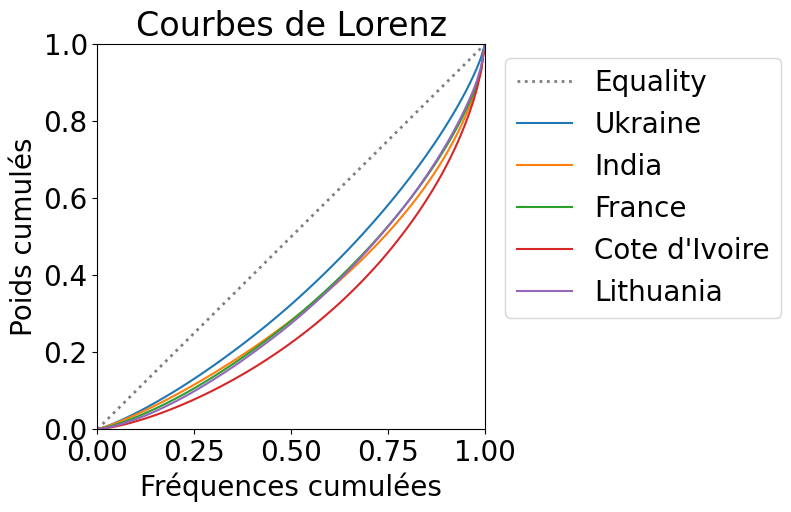

In [7]:
# set graph
plt.figure(figsize=(5,5),dpi=100)
plt.axis(xmin=0, xmax=1 ,ymin=0, ymax=1)
plt.ylabel('Poids cumulés')
plt.xlabel('Fréquences cumulées')
plt.title('Courbes de Lorenz')

# plot equality line
plt.plot([0, 1], lw=2, c='gray', ls='dotted', label='Equality')

for country_code in selected_countries:
    country_filter = incomes_filter[incomes_filter['country_code']==country_code]

    # compute lorenz curve
    cum_frequences, cum_weights = qe.lorenz_curve(np.array(country_filter['income']))
    
    # plot the Lorenz curve
    sns.lineplot(cum_frequences, cum_weights, label=country_filter['country_name'].unique()[0])

plt.legend(loc='upper right', bbox_to_anchor=((1.3, 0.5, 0.5, 0.5)))
plt.savefig('P7_02_lorenz.png', bbox_inches='tight');

# free memory space
del incomes_filter

- TimeSeries de l'indice de Gini des pays choisis

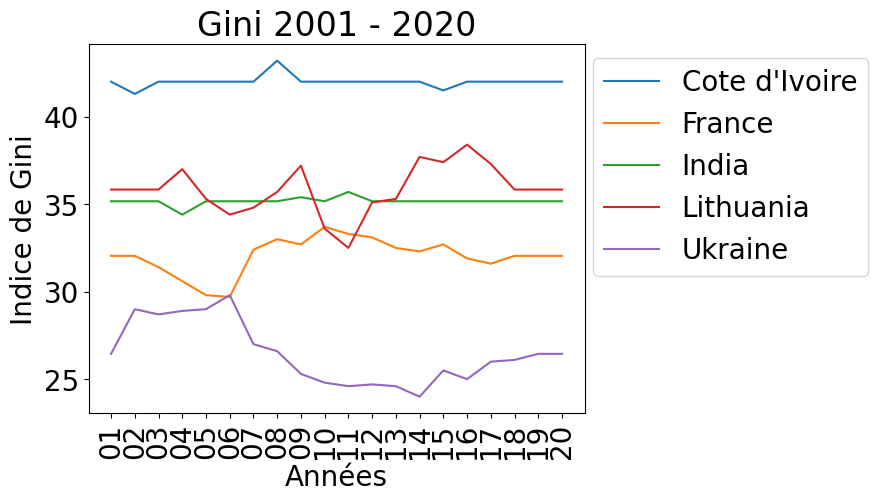

In [8]:
# data preparation : gini
gini_time_series = pd.read_csv('./dataset/worldbank_gini_population.csv')
gini_time_series = gini_time_series[gini_time_series['Series Name']=='Gini index (World Bank estimate)']
gini_time_series = gini_time_series.replace('..', np.nan)
gini_time_series = gini_time_series.iloc[:, 2:]
gini_time_series.iloc[:, 2:] = gini_time_series.iloc[:, 2:].astype(float)

# filter with selected countries
gini_time_series = gini_time_series[gini_time_series['Country Code'].isin(selected_countries)]
gini_time_series = gini_time_series.set_index('Country Name')

# droping column
gini_time_series = gini_time_series.iloc[:, 1:]

# transpose data for fitting time series
gini_time_series = gini_time_series.T

# keep the last 2 digits of years
gini_time_series.index = gini_time_series.index.str[2:4]

# mean's imputation for missing values
gini_time_series = gini_time_series.fillna(gini_time_series.mean())

# graph settings
for column_name in gini_time_series.columns:
    sns.lineplot(x=gini_time_series.index, y=gini_time_series[column_name], label=column_name)
    plt.xticks(rotation=90)
    plt.title('Gini 2001 - 2020')
    plt.xlabel('Années')
    plt.ylabel('Indice de Gini')
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 0.5, 0.5, 0.5))
    plt.savefig('P7_02_gini.png', bbox_inches='tight')
    
# free memory space
del gini_time_series

# Mission 3 : peupler les 100 classes de revenus des parents pour chaque quantile.

## coefficient d'élasticité par pays
mobilité intergénérationnelle des revenus. 0 : forte mobilité, 9 : faible mobilité.

In [9]:
# elasticity coefficient from GDIM
elasticity_coefficient = pd.read_csv('./dataset/GDIM.csv', usecols=['wbcode', 'region', 'IGEincome'])

# drop duplicate lines
elasticity_coefficient = elasticity_coefficient.drop_duplicates()
elasticity_coefficient = elasticity_coefficient.groupby(['wbcode', 'region']).mean().reset_index()

# missing values ratio
print('missing values ratio ', elasticity_coefficient['IGEincome'].isna().sum()/elasticity_coefficient.shape[0])

# median imputation for missing values
region = elasticity_coefficient.groupby('region').median()

for region_name in region.index :
    elasticity_coefficient.loc[(elasticity_coefficient['region']==region_name) 
                       & (elasticity_coefficient['IGEincome'].isna()), ['IGEincome']]=region.loc[region_name][0]
    
# delete region column, set wbcode index
elasticity_coefficient = elasticity_coefficient.iloc[:, [0, 2]]
elasticity_coefficient = elasticity_coefficient.set_index('wbcode')

# round by 1 decimal : no need more precision
elasticity_coefficient = elasticity_coefficient.round(1)
elasticity_coefficient

missing values ratio  0.5


,IGEincome
wbcode,
AFG,0.5
AGO,0.7
ALB,0.8
ARG,1.0
ARM,0.4
...,...
WBG,0.9
YEM,0.9
ZAF,0.7


## Générer les probabilités conditionnelles
Exemple de calcul conditionnel pour un coefficient d'élasticité donné.
En faisant varier le nombre de décimales du coefficient d'élasticité, on s'aperçoit qu'il n'est pas nécessaire de conserver plus d'une décimale grâce au graphique de la partie suivante.

In [10]:
start = time.time()

y_child, y_parent = generate_incomes(size=100000, elasticity_coefficient=0.9)

sample = compute_quantiles(y_child, y_parent, nb_quantiles=100)

cd = conditional_distributions(sample)

# print elapsed time
print(time.time()-start)

# get conditionnal probability for c_i_child=5 and c_i_parent=8
print("P(c_i_parent = {} | c_i_child = {}, pj = 0.9) = {}".format(8, 5, cd[4, 7]))

0.16684913635253906
P(c_i_parent = 8 | c_i_child = 5, pj = 0.9) = 0.04


## Vérifier la cohérence du code
- la couleur indique une densité supérieure de parents.
- j'ai simulé 1000 individus car la fonction que j'ai programmé ne me permettait pas de faire moins ( à cause des décimales de la matrice des probabilités condtionnelles)

abscisse : quantiles parents
ordonnée : quantiles enfants


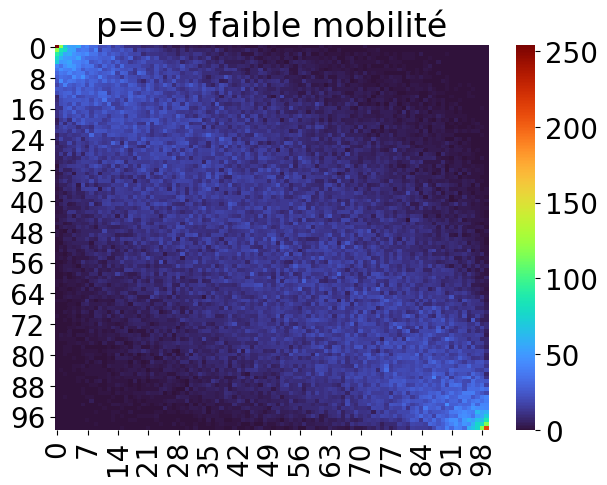

In [11]:
plt.figure(figsize=(7, 5))
plt.title ('p=0.9 faible mobilité')
sns.heatmap((cd * 1000), annot=False, cbar=True, cmap='turbo');
print('abscisse : quantiles parents')
print('ordonnée : quantiles enfants')

## Création du dataframe des coefficients d'élasticité

In [12]:
start = time.time()
elasticity_dataframe = pd.DataFrame()

for coefficient in elasticity_coefficient['IGEincome'].unique():
    elasticity_dataframe = pd.concat([elasticity_dataframe,elasticity_parent_class_dataframe(coefficient)])

# print elapsed time
print(time.time()-start)

1.468867540359497


## Création du dataframe des classes de parents par pays

In [13]:
dataset = elasticity_coefficient.copy()
dataset = dataset.reset_index()

dataset = dataset.merge(elasticity_dataframe,how='left', 
                        left_on='IGEincome', right_on='elasticity_coefficient')

dataset = dataset.drop(columns=['IGEincome', 'elasticity_coefficient'])
dataset = dataset.set_index(['wbcode'])

dataset

# free memory space
del elasticity_coefficient, elasticity_dataframe

## Intégrer l'indice de Gini

In [14]:
dataset = dataset.merge(gini[['country_code', 'gini_index']], left_index=True, right_on='country_code')
dataset = dataset.set_index('country_code')
dataset

# free memory space
del gini

## Intégrer les revenus moyens

In [15]:
# drop the country with missing quantile
incomes = incomes.set_index(['country'])
incomes = incomes.drop(index='LTU')

# resetting index for dataframe incomes
incomes = incomes.reset_index()
incomes = incomes.set_index(['country', 'quantile'])

# resetting index for dataframe dataset
dataset = dataset.reset_index()
dataset = dataset.rename(columns={'country_code' : 'country'})
dataset = dataset.set_index(['country', 'quantile'])

# merging with dataset
dataset = dataset.merge(incomes[['income']], left_index=True, right_index=True)

# droping child quantile
dataset = dataset.reset_index()
dataset = dataset.drop(columns='quantile')

# free memory space
del incomes 

## Fusionner les colonnes des quantiles parent en une seule colonne

In [16]:
# melt class parents
dataset = pd.melt(dataset, id_vars=['country', 'gini_index', 'income'], 
                  value_name='parent_quantity', var_name='parent_quantile')

# add 1 to quantile number
dataset['parent_quantile'] = dataset['parent_quantile'] + 1

# before repeating rows : deleting parent_quantity = 0
dataset = dataset[dataset['parent_quantity']!=0]

# create parent quantiles
repeat_list = pd.Series(dataset['parent_quantity'])
dataset = dataset[['country', 'gini_index', 'income', 'parent_quantile']]


dataset = dataset.apply(np.repeat,repeats=(repeat_list))

## Typer les données pour économiser de l'espace mémoire
https://numpy.org/devdocs/user/basics.types.html

- avant traitement : 408 MO
- après traitement : 163 MO

In [17]:
dataset['parent_quantile'] = dataset['parent_quantile'].astype(np.uint8)
dataset['income'] = dataset['income'].astype(np.uint32)
dataset['gini_index'] = dataset['gini_index'].astype(np.float16)
dataset['country'] = dataset['country'].astype('category')

dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10700000 entries, 0 to 1069999
Data columns (total 4 columns):
 #   Column           Dtype   
---  ------           -----   
 0   country          category
 1   gini_index       float16 
 2   income           uint32  
 3   parent_quantile  uint8   
dtypes: category(1), float16(1), uint32(1), uint8(1)
memory usage: 163.3 MB


# Mission 4

## VERIFICATION AVANT REGRESSION
- Les revenus doivent être compatibles avec une loi normale si nous voulons appliquer une regression linéaire. 

0.6792504787445068


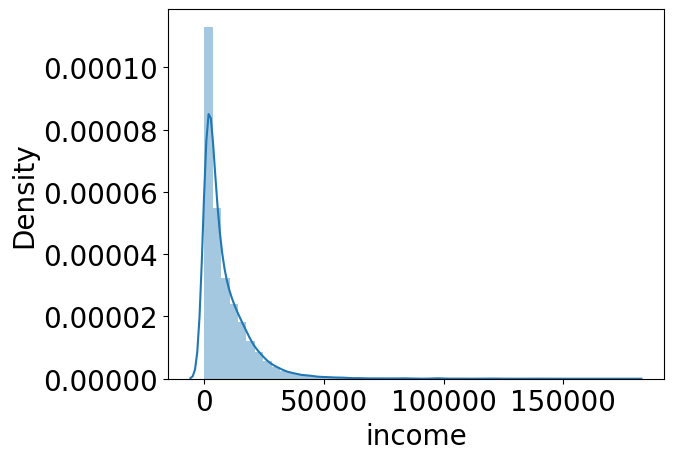

In [18]:
print(sp.stats.shapiro(dataset['income'].drop_duplicates())[0])
sns.distplot(dataset['income'].drop_duplicates());

0.9798027873039246


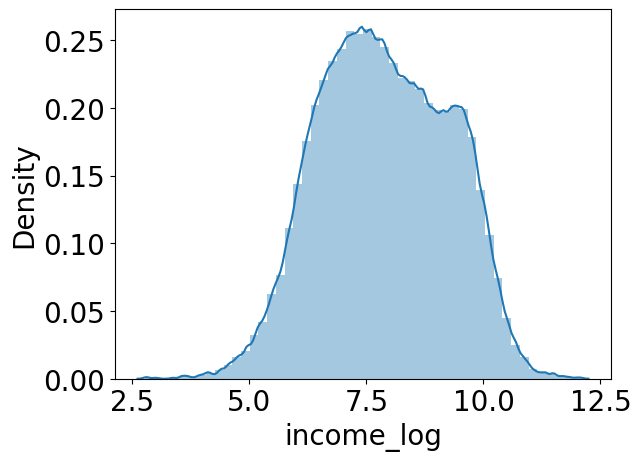

In [19]:
dataset['income_log'] = np.log(np.array(dataset['income']))

print(sp.stats.shapiro(dataset['income_log'].drop_duplicates())[0])
sns.distplot(dataset['income_log']);

- **la forme la plus 'normale' pour les revenus est sa version logarithmique.** 
- Un test de normalité par pvalue n'aurait pas donné de bons résultats car la distribution des revenus est bimodale.

## Régression linéaire avec statsmodel
- Régression linéaire sur données catégorielles.
- Sélection des pays avec un backward elimination.

In [20]:
from statsmodels.formula.api import ols

# data preparation
anova = dataset[['country', 'income']].drop_duplicates()
anova['income'] = np.log(anova['income'])
anova.columns=['country', 'log_income']

# fitting regression model
model = ols('log_income ~ country', data=anova).fit()
pvalues = model.summary2().tables[1][1:]['P>|t|']

# performance analysis
print(model.summary().tables[0])

                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:                       0.720
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     257.1
Date:                Thu, 04 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:31:05   Log-Likelihood:                -11762.
No. Observations:               10700   AIC:                         2.374e+04
Df Residuals:                   10593   BIC:                         2.452e+04
Df Model:                         106                                         
Covariance Type:            nonrobust                                         


### backward elimination :
- **étape 1** : fixer seuil : 0,01%
- **étape 2** : All-in pour commencer
- **étape 3** : enlever le pays où pvalue > seuil est la plus forte
- **étape 4** : itérer tant que la condition de l'étape 3 est vraie ( + corriger bug summary)

In [21]:
backward_elimination_countries=[]
critical_threshold = 1e-5

# while pvalues > pvalue threshold
while len(pvalues[pvalues > critical_threshold])!=0 :
    # selecting the country with the highest pvalue
    highest_pvalue_index = pvalues.argmax()
    country_name = pvalues.index[highest_pvalue_index][10:13]

    # removing country
    backward_elimination_countries.append(country_name)
    anova = anova[anova['country']!=country_name]
    
    # fitting linear regression model
    model = ols('log_income ~ country', data=anova).fit()
    
    # collecting pvalues in statsmodel summary2()
    pvalues = model.summary2().tables[1][1:]['P>|t|']
    
    # inverse filtering summary with country name already removed
    '''
    the statsmodels summary makes an infinitte loop :
    - country already removed with boolean indexing
    - summary returned country already removed
    - so pvalues list was never emptied
    '''
    pvalues = pvalues[pvalues > critical_threshold]
    pvalues = pvalues[~pvalues.index.str[10:13].isin(backward_elimination_countries)]

print(backward_elimination_countries)

['JOR', 'MEX', 'BRA', 'DOM', 'VEN', 'ZAF', 'PER', 'UKR', 'PAN', 'ECU', 'AZE', 'KAZ', 'PRY', 'SLV', 'COL', 'MNG', 'BLR', 'MKD', 'MDA', 'THA', 'CRI', 'URY', 'MAR', 'TJK', 'BGR']


In [22]:
# performance analysis
print(model.summary().tables[0])

                            OLS Regression Results                            
Dep. Variable:             log_income   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.782
Method:                 Least Squares   F-statistic:                     363.4
Date:                Thu, 04 Feb 2021   Prob (F-statistic):               0.00
Time:                        16:31:07   Log-Likelihood:                -8640.9
No. Observations:                8200   AIC:                         1.745e+04
Df Residuals:                    8118   BIC:                         1.802e+04
Df Model:                          81                                         
Covariance Type:            nonrobust                                         


## Régression linéaire : donnée catégorielle
Ceci est la version scikit learn.

In [23]:
# data preparation
linear = dataset[['country', 'income']].drop_duplicates()
linear['income'] = np.log(linear['income'])

# categorical data encoding
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [0])], 
                       remainder='passthrough', sparse_threshold=0)

linear = np.array(ct.fit_transform(anova))


coeff, intercept, residuals = regression_coeff_score(X=linear[:,:-1], y=linear[:,-1].reshape(-1, 1))

# free memory space
del linear

R² train : 0.77
R² test : 0.79


## Suppression de pays suite au backward elimination

In [24]:
# removing countries in main dataframe
dataset = dataset[~dataset['country'].isin(backward_elimination_countries)]

# checking population ratio
population_ratio(country_code_list=dataset['country'].unique())

data population / total population  0.792373288115942


## Régression multiple numéro 1
- variable à expliquer : logarithme des revenus (des enfants)
- variable explicative : indice de Gini du pays et logarithme du revenu moyen du pays

In [25]:
start = time.time()

# compute country mean income
country_mean_income = dataset[['country', 'income']].groupby('country').mean()
country_mean_income.columns=['country_mean_income']
dataset = dataset.merge(country_mean_income, how='left', left_on='country', right_index=True)

# data preparation
regression = dataset[['income', 'country_mean_income', 'gini_index']].drop_duplicates()
regression['income'] = np.log(regression['income'])
regression['country_mean_income'] = np.log(regression['country_mean_income'])
regression = np.array(regression)

# fitting regression
coeff, intercept, residuals = regression_coeff_score(X=regression[:,1:] , y=regression[:, 0].reshape(-1, 1))


# free memory space
del regression

print(time.time() - start)
print(coeff, intercept)

R² train : 0.78
R² test : 0.79
1.682887077331543
[[ 0.99035888 -0.01679075]] [0.44876511]


## Vérifier la normalité des résidus

False


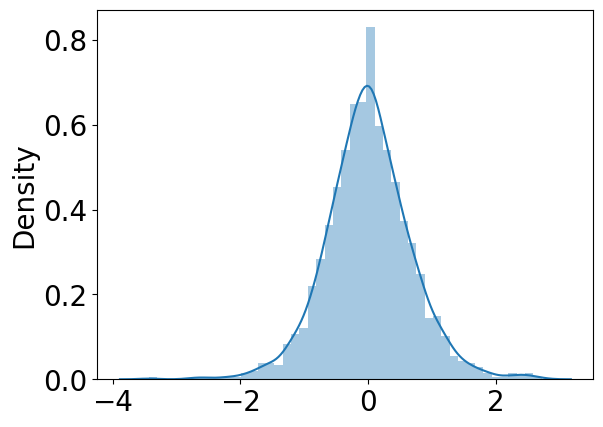

In [26]:
# check residuals normality
print(shapiro_boolean(residuals))
sns.distplot(residuals);

## Régression multiple numéro 2
- variable à expliquer : logarithme des revenus (des enfants)
- variables explicatives : indice de Gini et classe de revenus des parents

In [27]:
start = time.time()

# data preparation
dataset = dataset[['income', 'country_mean_income', 'gini_index', 'parent_quantile']]
dataset['income'] = np.log(dataset['income'])
dataset['country_mean_income'] = np.log(dataset['country_mean_income'])
dataset = np.array(dataset)

# fitting regression
coeff, intercept, residuals = regression_coeff_score (X=dataset[:,1:], y=dataset[:,0].reshape(-1, 1))

print(time.time() - start)
print(coeff, intercept)

R² train : 0.82
R² test : 0.82
35.91757893562317
[[ 0.98586302 -0.01730611  0.01045756]] [-0.02270698]


## Vérifier la normalité des résidus

True


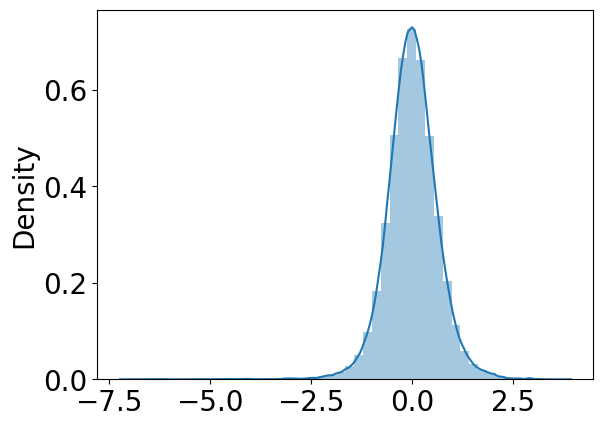

In [28]:
# check residuals normality
print(shapiro_boolean(residuals))
sns.distplot(residuals);

## Description de la variable dépendante après backward elimination
- distribution bimodale : les échantillons proviennent de 2 populations statistiques différentes
- ces 2 population statistiques représentent 80% de la population totale

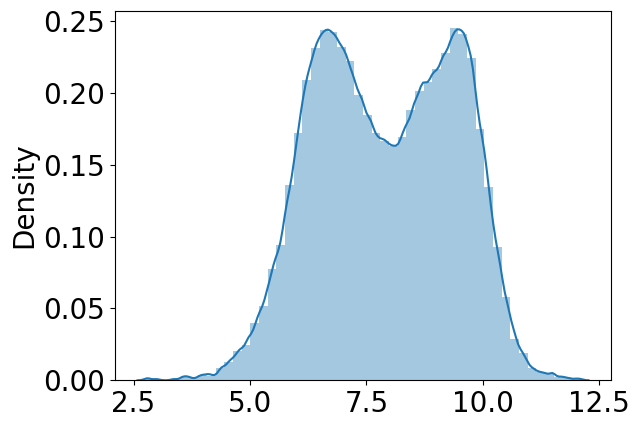

In [29]:
sns.distplot(dataset[:,0]);

# free memory space
%reset -f